# AutoClassify: Vision Transformer for Vehicle Recognition
Introduction

The detection and classification of vehicles play a vital role in enhancing traffic management and forecasting systems. Classifying cars is particularly relevant for applications such as traffic monitoring and enhancing vehicular safety by identifying high-risk vehicle types. In this project, we will use a pretrained Vision Transformer  model to classify around 196 car models from the Stanford Cars Dataset. Our approach will involve examining the dataset to understand its contents, preparing the data to ensure it is compatible with our model using PyTorch, and then training and evaluating the model to assess its accuracy in classifying various car models. We will also be using the weights and biases library to log and visualize training. In

What will we learn?

- Multi Class Classification
- Data Augmentation
- Feature Extractors
- Vision Transformer Architecture
- Transfer Learning
- Observation of Weights & Biases

As always, we load the necessary packages, set directories and load necessary models.  

In [ ]:
!pip install wandb
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification
from tqdm import tqdm
from google.colab import drive
from functools import partial
from dotenv import load_dotenv
import wandb
wandb.login(key=os.getenv("WANDB_API_KEY"))
wandb.init()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
drive.mount('/content/gdrive')
train_dir ='/content/gdrive/MyDrive/car_data/train'
test_dir = '/content/gdrive/MyDrive/car_data/test'

classes = os.listdir(train_dir)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

Mounted at /content/gdrive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


As a next step, we try to get an intuiton of the dataset. We already know that our dataset is organized by categories of car models in different folders

Train Dataset


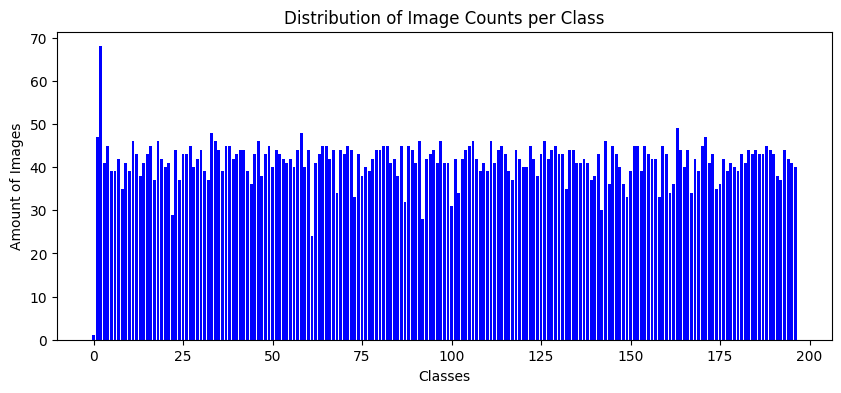

The Dataset containts 196 classes and 8145 images. 
 
Test Dataset


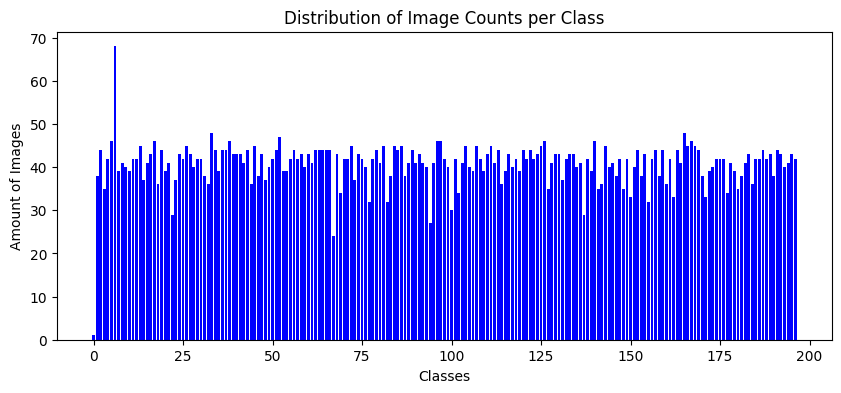

The Dataset containts 196 classes and 8042 images. 
 


In [ ]:
def   analyze_dataset(dir):
  file_count = 0
  all_entries = os.listdir(dir)
  dir_count = sum(os.path.isdir(os.path.join(dir, entry)) for entry in all_entries)
  file_counts = []

  for dir, models, pic in os.walk(dir, topdown=True):
    file_per_class = 0
    for name in pic:
      file_per_class +=1
      file_count += 1
    file_counts.append(file_per_class)

  plt.figure(figsize=(10, 4))
  plt.bar(range(len(file_counts)), file_counts, color = "blue")
  plt.xlabel("Classes")
  plt.ylabel("Amount of Images")
  plt.title(f"Distribution of Image Counts per Class")
  plt.show()

  print(f"The Dataset containts {dir_count} classes and {file_count} images. \n ")

print("Train Dataset")
analyze_dataset(train_dir)
print("Test Dataset")
analyze_dataset(test_dir)


As there is no major skewing in the image counts, we can leave the dataset as is. Furthermore, these Numbers gives a good first perspective on the dataset itself, but also on the specific difficulties and challenges that come with it. This brings us to the challenge of <u>multi class classification</u>. It involves not only recognizing e.g. the car but also distinguishing between very similar models and years. Many car models may only have minor visual differences, thus resulting in a more challenging task for the model to accurately differentiate images. Variations within the classes like modifications or aspects like varying image quality and background noise pose additional challenges.

After we have acknowledged this, we put our attention to the predefined 50/50 split and decide to change this to a 80/20 split for better training. 

We will do this by selecting images from the classes in the test dataset and moving them to the respective directory in the train datset.

In [ ]:
subdirs_train = sorted(os.listdir(train_dir)) 
train_files = []

# itarate through all subdirectories of the training data
for subdir in subdirs_train:
  for dir, sdir,imgs in os.walk(os.path.join(train_dir, subdir)):
    for img in imgs:
      # add image paths together with labels to train_files
      train_files.append((os.path.join(train_dir, subdir, img), subdir))

# Do the same with testing data
subdirs_test = sorted(os.listdir(test_dir))
test_files = []
for subdir in subdirs_test:
  for dir, sdir, imgs in os.walk(os.path.join(test_dir, subdir)):
    img_per_class = len(imgs)
    # 3200/8045 ≈ 0.4, meaning with our new split, roughly 40% of test data remains
    transf_img = round(img_per_class * 0.4)
    test_img_counter = 0
    for img in imgs:
        # add images and labels to test_files, until our threshhold of 40% is reached
        if(test_img_counter <= transf_img):
            test_files.append((os.path.join(test_dir, subdir, img), subdir))
            test_img_counter += 1
        # add the rest to our training data
        else:
            train_files.append((os.path.join(test_dir, subdir, img), subdir))

The next step of our pipeline is to define a Dataset_Handler Class. In this Class we do an intilization with files, labels, the feature extractor and an optional augment flag. The latter is used to enable <u>Data Augmentation</u>, a  technique we chose to enrich the diversity of our training data. This is done without acutally collecting new data by applying random, yet realistic transformations to our images, like rotating, flipping or britghtnening. This adds to the variations of the data that might realisticly occur, therefore increasing the robustness of our model.

We create two dunder methods to assist in further processing our data later in the pipeline. "getitem" fetches imaage-label pairs, converts images to RGB, applies the above augmentation and then uses the provided <u>Feature Extractor</u> to preprocess the image into a tensor, suitable for model training. This feature extractor processes the raw pixels of the images into a suitable format for our model to train on. Fruthermore it identifies and isolates relevant characteristics, thus enriching our data further. For a computer vision task, these feature extractors are essentially CNNs.

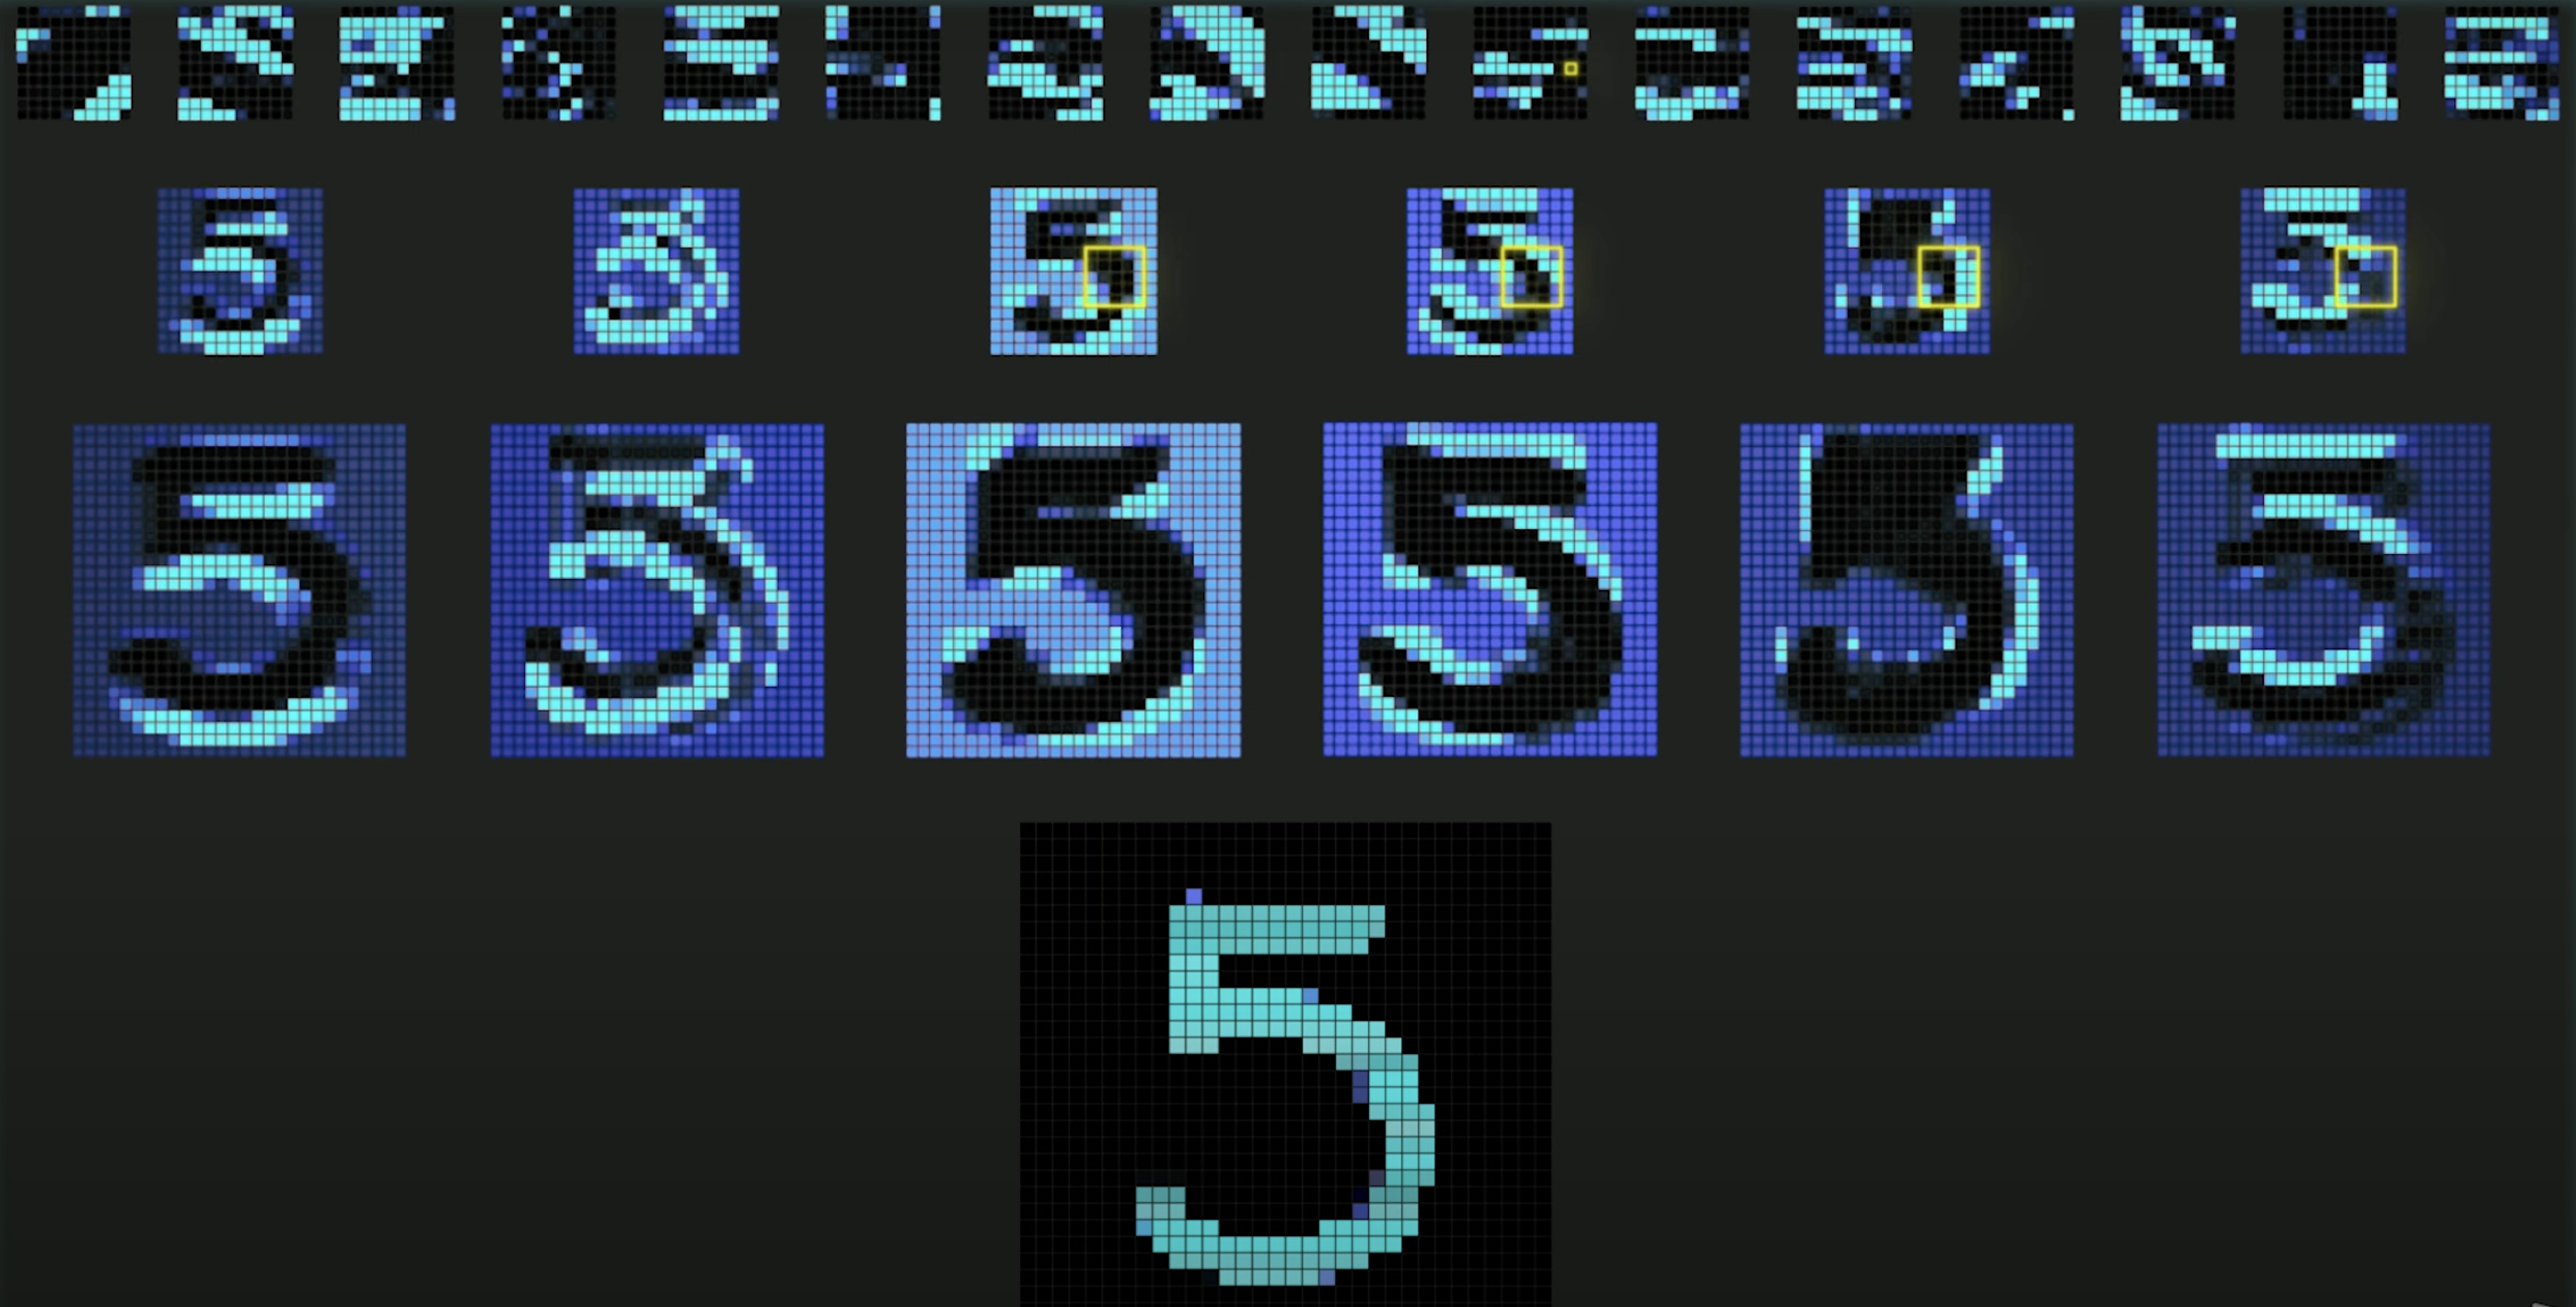
<div align="center">
  <br>
  Source: https://www.youtube.com/watch?v=pj9-rr1wDhM&t=389s
<br>
</div>

They apply convlutional operations by utilizing filter matricies on the raw pixels. These "convolute" over the grid shaped data, to extract different feature maps, all denoting different nuances of the presented data, visualized in the first two rows of the graphic above. Dimensionality reduction is another cruicial task in which, for our example, raw pixel values of an image get reduced to a lower-dimensional space. Critical information is still retained, even though not visible to the naked eye, as seen (or not seen lol) in the last row of the above picture.

The latter of the two methods, "len", returns the total numbers of files in the dataset.

In [ ]:
class Dataset_Handler():

    def __init__(self, files, feature_extractor, labels,augment = True):
        self.feature_extractor = feature_extractor
        self.files = files
        self.labels = labels
        self.augment = augment

        # augment setup
        self.augment_transforms = transforms.Compose([
            transforms.ColorJitter(brightness = 0.5, contrast = 0.3),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=45),
            transforms.RandomVerticalFlip(p=0.05)
        ])

        # convert to rgb, apply augmentation and extract features
    def __getitem__(self, index):
        img, label = self.files[index % len(self.files)]
        img = Image.open(img).convert("RGB")

        if self.augment:
          img = self.augment_transforms(img)

        img = self.feature_extractor(img, return_tensors="pt")
        img["labels"] = torch.tensor(self.labels.index(label))
        return img

    def __len__(self):
        return len(self.files)

In [ ]:
# set instances of classes
train_dataset = Dataset_Handler(train_files, feature_extractor, classes)
test_dataset = Dataset_Handler(test_files, feature_extractor, classes)
#split dataset
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [2417, 1000])

For the next step in our preprocessing, we will set up DataLoader objects from the PyTorch library for our datasets. These DataLoaders are essential for efficiently managing the flow of data into models like the Vision Transformer. They streamline the tasks of loading, batching, and preparing data, which are vital for effective and efficient model training and inference.

In [ ]:
# Set variables for batch processing
batch_size = 32
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

As we are not far from getting into the training process, we deicde to take a look at some individual images, to make sure that our dataset has been preprocessed in the desired way.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


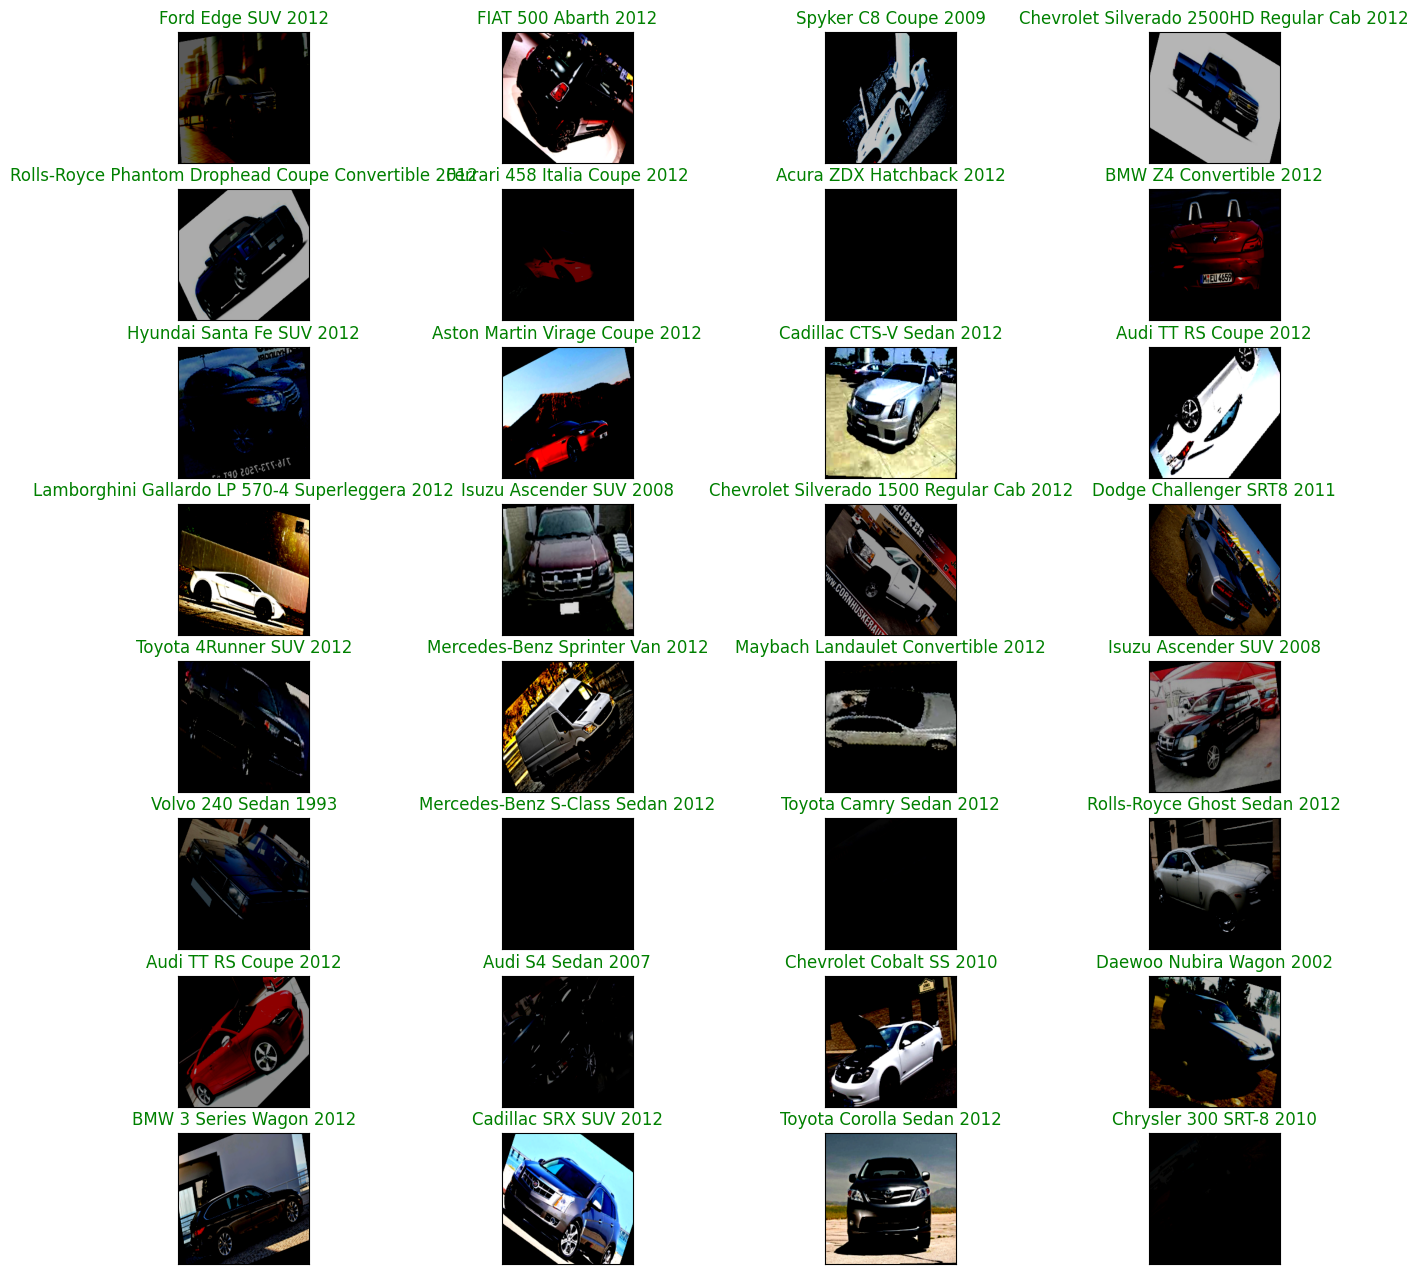

In [ ]:
batch = next(iter(train_loader))
batch_images = batch["pixel_values"]
batch_labels = batch["labels"]

plt.figure(figsize=(16,16))

for i in range(batch_size):
    plt.subplot(8,4,i+1)
    label_position = batch_labels[i].item()
    label = train_dataset.labels[label_position]
    plt.title(label, color="green")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(batch_images[i].squeeze().permute(1, 2, 0).cpu())
plt.show()

We can see, that images have been correctly ordered to their labels and augmentations have been performed.

Now, it is time to intilize our training setup. We utilize our GPU and set various training parameters, of which some we are using for tracking with the wanb library

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_epochs = 7
lr = 2e-4
eval_steps = 100
record_steps= 10 # for monitoring and debugging
save_checkpoint = 5 # for recovery, saving state of model
training_stats_step = 10 # negative log likelihood -> multi-class classification

wandb.config.update({"lr": lr, "num_epochs": num_epochs})

As a next step, we load our Model, the Vision Transformer (ViT). It was first Introduced in the Paper "*An image is worth 16x16 words: Transformers for image recognition at scale*"  by Google Brain in 2021 (https://arxiv.org/abs/2010.11929). <br> To get an understanding of the model, we are going to take a closer look at its Architecture. <br> <br>
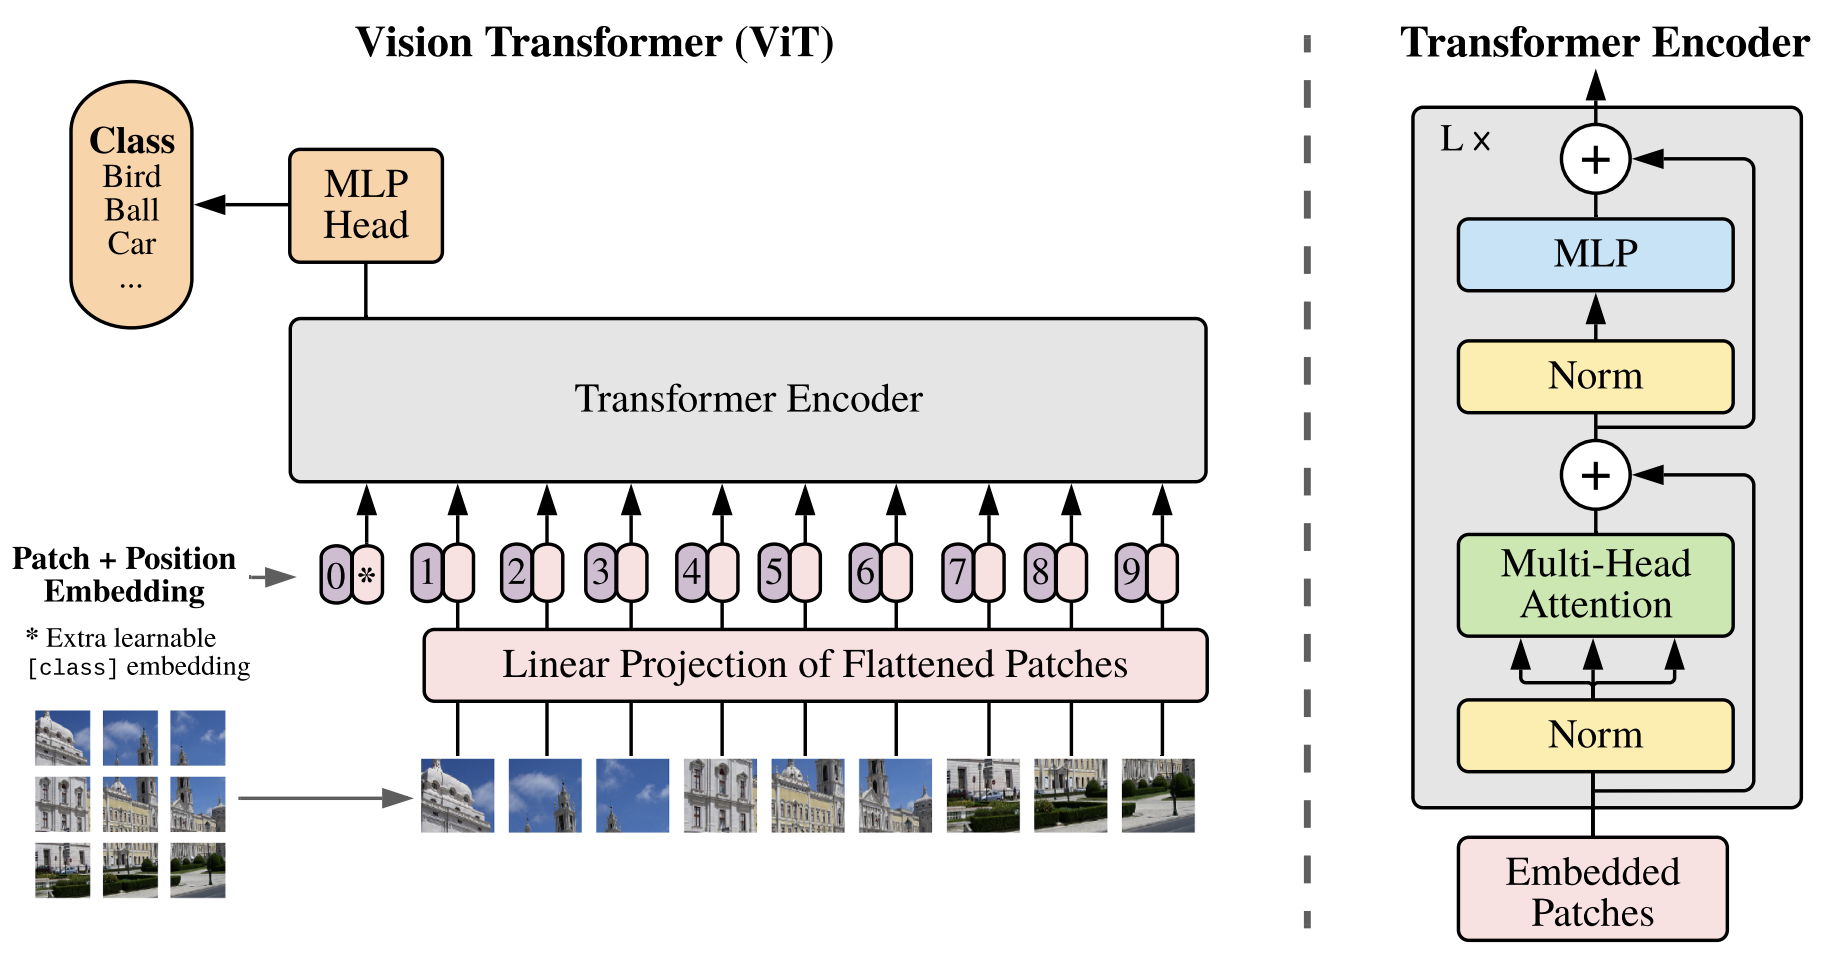
The ViT Architecture is based on the vanilla Transformer in that its core concept is to treat image patches as tokens, similar to e.g. word embeddings in the vanilla architecture.
These <u>patches</u> are created by dividing an image into 16x16 pixel sized patches. These then get flattened into a one-dimensional vector. Considering the RGB color channels, each vector has a length of 16x16x3 = 786.
These flattened patches are then projected into a higher-dimensional space using trainable <u>linear Projection</u>.

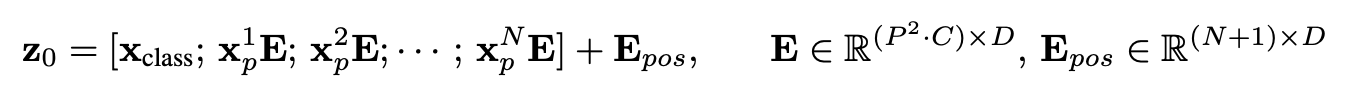

Each patch Xip is is multiplied by the embedding matrix E. E is the embeddings matrix that projects the flattened patches into a higher-dimensional space D. As denoted on the right of the above equation, this matrix has the dimensions '( P2 x C)' x D, where P2 x C is the dimensionality of each patch, and C the color channel (16x16x3 = 786 per patch). Epos is the position embedding matrix, with dimensions (N+1)xD, where N is the number of patches and +1 is added for an additional class token. <br>
The resulting embedded patches are concatenated with the <u>Xclass-Token</u> and positional embeddings
The class token is analogus to the [CLS] token used in BERT for NLP tasks. As the image patches pass through the transformers layers, this class token is updated at each layer, mainly based on self-attention interactions with the patch embeddings. The last state/ last embedding of this class token is used to to make the final prediction, by passing it through a classification head. <br><u>Positional Embeddings</u>, values of sinusoidal functions,  are added to the sequence as well.
The idea behind using these functions is in their periodic and continuous nature, therefore adding a combination of function values to the sequence allows for a model to understand the positional information.  
The final embeddings make their way into an <u>Encoder</u>. After Normilization, they are passed to the core of the encoder, a <u>Multi-Head Attention</u>  Block.  Three copies of the entire input embedding matrix are generated in the Multi-Head Attention Block, known as Query, Key, and Value matrices. Dot product attention is then calculated between the Query and Key matrices to produce a weighting matrix, which captures the nuanced relationships between all input vectors towards each other. This weighting matrix is subsequently used to weight the Value matrix, resulting in a new, enriched matrix that contains contextual information about the data. This process is performed multiple times independently, with different learned projections for each head. Residual connections are added and Normilization is performed once more, before the sequence is passed through a MLP module, introducing non-linearity to the model, similar to a feedforward layer in the vanilla transformer. <br>This entire Encoder Module is repeatet L times before the Sequence makes its way to a final MLP Head, that performs the classification through the final embedding of the class token.
<br>
<br>

In the below code, we load a pretrained Vision Transformer.

In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=len(classes),
                                                   id2label={str(i): c for i, c in enumerate(classes)},
                                                   label2id={c: str(i) for i, c in enumerate(classes)},
                                                   ignore_mismatched_sizes=True).to(device)

The term pretrained brings us to our next term. <u> Transfer Learning </u> refers to the practice of taking a model that has already been trained on a large and general dataset and further train/ fine-tuning it on a new, typically smaller, dataset that is specific to the desired task. This is done because training a large model, e.g. a Vision Transformer from scratch can take weeks and months, when utlizing hundreds of GPUs. 
Ressources that we certainly dont have and therefore happly load a pretrained version. 

Next in our pipeline, we define a straightforward function to evaluate our models performance. This function calculates the models accuracy and loss on the evaluation dataset by comparing predicted labels with true labels and averaging the loss over all batches.

In [ ]:
# ADAM optimizer and StepLP as learning rate scheduler
optim = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = StepLR(optim, step_size=1, gamma=0.6)

def evaluate(model, eval_loader, eval_dataset):

    # keep track of predictions
    correct = 0
    eval_loss = []

    model.eval()
    for batch in tqdm(eval_loader):
        # extract images and labels from batch
        batch_images = batch["pixel_values"].squeeze(1).to(device)
        batch_labels = batch["labels"].to(device)

        # Evaluation without gradients
        with torch.no_grad():
            outputs = model(pixel_values=batch_images, labels=batch_labels)
            loss = outputs[0]
            eval_loss.append(loss.item())
            #retrieves logits, convert into labels, compare to true labels,
            #sum up correct predictions, extract scalar value with .item()
            correct += (torch.argmax(outputs["logits"], dim=1) == batch_labels).sum().item()

    # accuracy and loss
    accuracy = (100 * correct / len(eval_dataset))
    avg_loss = (sum(eval_loss) / len(epoch_loss))

    return accuracy, avg_loss

Finally, we put everything together to train and evaluate our model. In this training loop, we iterate through each epoch, performing forward and backward passes, updating weights, and logging metrics. After each epoch, we evaluate the model on the validation set to monitor its performance and adjust the learning rate using the scheduler.

In [ ]:
# progress bar
tqdm = partial(tqdm, position=0, leave=True)

# training loop
for epoch in range(1, num_epochs+1):
    epoch_loss = []
    epoch_acc = []

    print("Epoch", epoch)
    for index, batch in enumerate(tqdm(train_loader)):
        model.train()
        optim.zero_grad()

        # extract images and labels from batch
        batch_images = batch["pixel_values"].squeeze(1).to(device)
        batch_labels = batch["labels"].to(device)
        size = len(batch_images)

        # forward pass
        outputs = model(pixel_values=batch_images, labels=batch_labels)
        loss = outputs[0]
        epoch_loss.append(loss.item())

        # backward
        loss.backward()
        optim.step()

        # calc accuracy, same as in evaluate()
        correct = (torch.argmax(outputs["logits"], dim=1) == batch_labels).sum().item()
        acc = (100 * correct) / size
        epoch_acc.append(acc)

        # track training with wandb
        if index % record_steps == 0:
            wandb.log({'loss': loss, "acc" : acc})


        # calc avg for all epochs
    avg_accuracy = (sum(epoch_acc) / len(epoch_acc))
    avg_loss = (sum(epoch_loss) / len(epoch_loss))

    #update loss
    scheduler.step()

    #validate
    val_acc, val_loss = evaluate(model, val_loader, val_dataset)
    wandb.log({'validation accuracy': val_acc, "validation loss" : val_loss})

    # summary
    print("evaluating on validation set")
    print(f"val loss: {round(val_loss, 4)}, val acc: {round(val_acc, 4)}%")
    print(f"Epoch: {epoch}  avg loss: {round(avg_loss, 4)} avg acc: {round(avg_accuracy, 4)}%")

Epoch 1


100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


evaluating on validation set
val loss: 0.163, val acc: 51.8%
Epoch: 1  avg loss: 3.7338 avg acc: 21.8515%
Epoch 2


100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


evaluating on validation set
val loss: 0.0811, val acc: 73.6%
Epoch: 2  avg loss: 1.1888 avg acc: 72.7522%
Epoch 3


100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


evaluating on validation set
val loss: 0.0585, val acc: 81.5%
Epoch: 3  avg loss: 0.5363 avg acc: 88.2519%
Epoch 4


100%|██████████| 32/32 [00:07<00:00,  4.32it/s]


evaluating on validation set
val loss: 0.0482, val acc: 85.7%
Epoch: 4  avg loss: 0.319 avg acc: 93.5699%
Epoch 5


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


evaluating on validation set
val loss: 0.0474, val acc: 85.3%
Epoch: 5  avg loss: 0.2245 avg acc: 95.943%
Epoch 6


100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


evaluating on validation set
val loss: 0.0437, val acc: 86.3%
Epoch: 6  avg loss: 0.174 avg acc: 96.9455%
Epoch 7


100%|██████████| 32/32 [00:07<00:00,  4.10it/s]

evaluating on validation set
val loss: 0.0436, val acc: 85.4%
Epoch: 7  avg loss: 0.1528 avg acc: 97.4937%


Last but not least, lets see how we did by having the model classsify the test set.

In [ ]:
test_acc, test_loss = evaluate(model, test_loader, test_dataset)
print(f"testing acc: {round(test_acc, 4)}%, testing loss: {round(test_loss, 4)}%")

100%|██████████| 76/76 [00:19<00:00,  3.97it/s]

testing acc: 86.1398%, testing loss: 0.098%


With testing results of 86% Accuracy and >0.1% loss, I am satisfied with this first version of the model and the project. I have applied a VisionTransformer for the sake of using one, not because it is the best model for this specific task. CNNs that are tailored to this specific Dataset give us benchmark accuracys of around 90%.

Plans to further optimize this Project in the near future include:

- Hyperparameter Tuning
- Regularization
- Optimize Data Augmentation
- Do more visulaization with wanb

This project has been an enjoyable and informative, giving valuable insights into the strengths and limitations of the Vision Transformer Architecture and Stanford Cars Dataset.
I look forward to further improving the model and achieving even better performance in future iterations. Thank you for following my journey in this exciting computer vision endeavor! Many more are to come!